# Retail Product Detection with FiftyOne and YOLOv8

In the fast-paced retail environment, **automation at checkout** is increasingly essential. Accurate detection and classification of products can significantly enhance operational efficiency, reduce human error, and improve the overall customer experience. 

This notebook demonstrates a streamlined approach to retail product detection using the **Retail Product Checkout (RPC) dataset**, which consists of:

- **200 retail Stock Keeping Units (SKUs)** across 17 meta-categories, including **puffed food, dried food, drinks**, and more.

To achieve precise detection and classification, we utilize **YOLOv8**, known for its speed and accuracy in real-time object detection tasks. In addition, we integrate **FiftyOne**, an open-source toolset for computer vision, to simplify data loading, training, evaluation, and visualization.

### Notebook Overview
This notebook will guide you through the following steps:

1. **Loading and Preparing the RPC Dataset**  

   Using FiftyOne, we’ll efficiently manage and prepare the RPC dataset for training and evaluation.

2. **Evaluating Model Performance**  

   With FiftyOne’s evaluation tools, we’ll analyze the performance of our YOLOv8 model in detecting and classifying retail products.

3. **Visualizing Detection Results**  

   We’ll use FiftyOne’s interactive tools to display results, including detection metrics and easy-to-understand visualizations of the model’s performance.

By the end of this notebook, you will have a comprehensive understanding of how to leverage FiftyOne and YOLOv8 for effective retail product detection, with insights into improving detection accuracy and deploying re


## Setup

### Step 1: Create a Virtual Environment

Before installing any libraries, it's a good practice to isolate your project dependencies by creating a virtual environment 

 `python3 -m venv retail-env`

### Step 2: Install Necessary Libraries

1. **Install FiftyOne** 

    `pip install fiftyone`

2. **Install PyTorch**

    `pip install torch torchvision torchaudio`

3. **Install Ultralytics (YOLOv8)**

    `pip install ultralytics`

### Step 3: Verify Installations


In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import fiftyone as fo
import fiftyone.brain as fob
import os
import matplotlib.pyplot as plt
import json
from glob import glob
from ultralytics import YOLO

In [2]:
# Verify FiftyOne
print(f"FiftyOne version: {fo.__version__}")

# Verify PyTorch
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

FiftyOne version: 1.0.1
PyTorch version: 2.5.0+cu124
Is CUDA available: True


## Load the RPC Dataset

To load the Retail Product Checkout (RPC) dataset in your notebook, we first need to guide you through downloading the dataset and organizing it into the data folder.

### Step 1: Download the Dataset
Visit the RPC dataset page and download the dataset archive. Here is the link to the dataset: [RPC Dataset](https://www.kaggle.com/api/v1/datasets/download/diyer22/retail-product-checkout-dataset). This will provide you with a compressed file containing the dataset (~15GB).

### Step 2: Dataset Preparation

1. **Extract**:
   - Extract its contents (images -> `data` and annotations -> `labels.json`) into the following folders within your project directory:
     - `train_dataset` for training data
     - `val_dataset` for validation data
     - `test_dataset` for test data

2. **Define Dataset Paths**:
   - We define the dataset names and relative paths for easy access within the code.

Note: Ensure that the extracted folders (train, val, and test) are located within the paths specified by DATASET_PATHS to avoid path errors in the project.

In [2]:
# Dataset names
DATASETS = {
    "train": "RPC-dataset-train",
    "val": "RPC-dataset-val",
    "test": "RPC-dataset-test"
}

# Relative dataset paths
BASE_DIR = os.path.join(os.getcwd(), "..")
DATASET_PATHS = {
    "train": os.path.join(BASE_DIR, "train_dataset"),
    "val": os.path.join(BASE_DIR, "val_dataset"),
    "test": os.path.join(BASE_DIR, "test_dataset")
}

### Update to `labels.json`

To align with FiftyOne’s label schema, we modified the `labels.json` file by renaming the `"supercategory"` field to `"name"` in each category entry. 

This change allows FiftyOne to interpret the `"name"` field as the primary label, ensuring that `supercategory` values are now read as labels for easier organization and filtering during visualization and analysis.

**Summary of Change**:

- **Before**: `"supercategory": "category_name"`

- **After**: `"name": "category_name"`


In [ ]:
# a little change in the json file to make 'supercategory' as 'name' in test file to visualize
def update_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Check and update each item in the 'categories' list
    for category in data.get("categories", []):
        # Rename 'name' to 'specific_label'
        if 'name' in category:
            category['specific_label'] = category.pop('name')
        # Rename 'supercategory' to 'name' 
        if 'supercategory' in category:
            category['name'] = category.pop('supercategory')
        
    
    # Save the modified data back to the file
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

json_file = DATASET_PATHS['test'] + '/labels.json'

# Apply the update for each file in the list
update_json_file(json_file)
print(f"Updated {json_file}")


Updated /mnt/c/Users/vanshika/Desktop/GitHub/voxel51/Retail_Product_51/../val_dataset/labels.json


In [128]:
def create_dataset(name, path, dataset_type=fo.types.COCODetectionDataset):
    """
    Creates a FiftyOne dataset from a specified directory.

    Args:
        name (str): The name of the dataset.
        path (str): The directory path to the dataset.
        dataset_type: The type of dataset. Defaults to COCODetectionDataset.

    Returns:
        fo.Dataset: The created FiftyOne dataset.
    """
    return fo.Dataset.from_dir(
        dataset_dir=path,
        dataset_type=dataset_type,
        name=name,
    )

# Create datasets
train_dataset = create_dataset(DATASETS["train"], DATASET_PATHS["train"])
val_dataset = create_dataset(DATASETS["val"], DATASET_PATHS["val"])
test_dataset = create_dataset(DATASETS["test"], DATASET_PATHS["test"])

# View summary info about the dataset
print(train_dataset)

# Print the first few samples in the train_dataset
print(train_dataset.head())

 100% |█████████████| 53739/53739 [1.3m elapsed, 0s remaining, 613.2 samples/s]      
 100% |███████████████| 6000/6000 [57.0s elapsed, 0s remaining, 58.2 samples/s]       
 100% |█████████████| 24000/24000 [3.9m elapsed, 0s remaining, 66.5 samples/s]       
Name:        RPC-dataset-train
Media type:  image
Num samples: 53739
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
[<Sample: {
    'id': '6726d57d5105e81ee6270255',
    'media_type': 'image',
    'filepath': '/mnt/c/Users/v

## Dataset Overview

The dataset includes rich metadata that facilitates efficient identification and detailed analysis. Below is a breakdown of the key metadata fields and their purposes:

1. **Name**  
   - A unique identifier for the dataset, either user-defined or auto-generated based on creation date and time.
   - Example: `RPC-dataset-train` 

2. **Media Type**  
   - Specifies the type of media in the dataset.
   - Example: `image` (indicating the dataset contains image data).

3. **Num Samples**  
   - Represents the total number of media samples (images/videos) within the dataset.
   - Example: `24000` samples for the test dataset.

4. **Persistent**  
   - A Boolean field indicating if the dataset is saved persistently or temporarily exists in memory.
   - Example: `True` (indicating the dataset is persistent).

5. **Tags**  
   - A list of user-defined tags to categorize or label the dataset.
   - Example: `[]` (currently, no tags are assigned).

6. **Sample Fields**  
   Each sample in the dataset contains various fields that capture important details:
   
   - `filepath`: The path to the sample’s media file.
   - `ground_truth`: Contains ground-truth object detection annotations, including bounding boxes and labels.


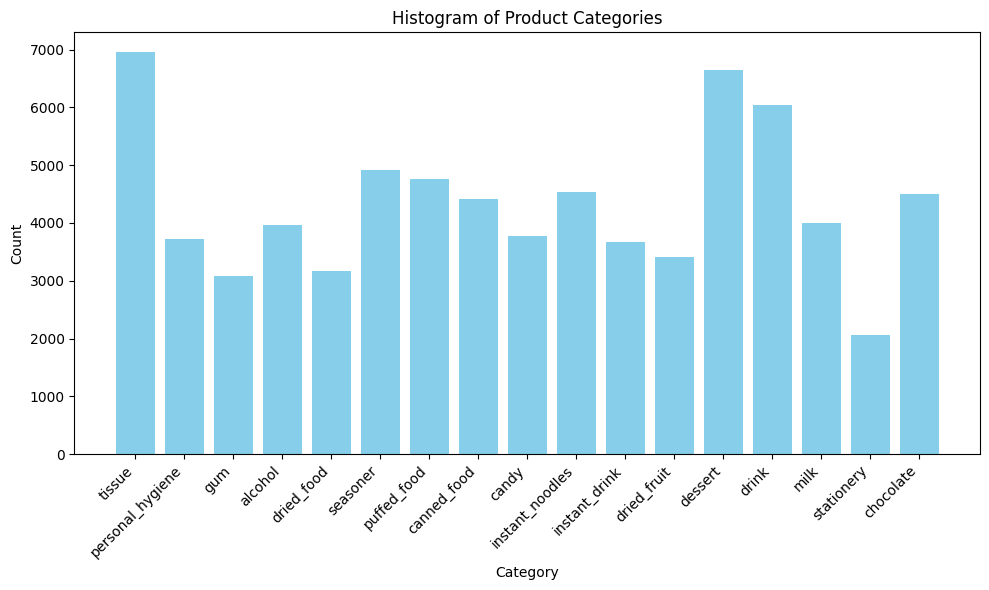

In [129]:
count = val_dataset.aggregate(fo.CountValues("detections.detections.label"))

# Extract keys and values for plotting
categories = list(count.keys())
values = list(count.values())

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Histogram of Product Categories")
plt.tight_layout()
plt.show()

## Inspecting Image Quality

Assessing image quality before feeding images into the model is crucial for ensuring detection accuracy. Poor-quality images, such as those that are blurred, can negatively impact the model’s performance.

In this example, we identify and tag blurred images in the `train_dataset`. Identifying these issues helps in refining the dataset and improving the model’s effectiveness.

For more tools to inspect image quality, including checks for **aspect ratio, brightness**, and other quality metrics, visit this [GitHub repository](https://github.com/jacobmarks/image-quality-issues).


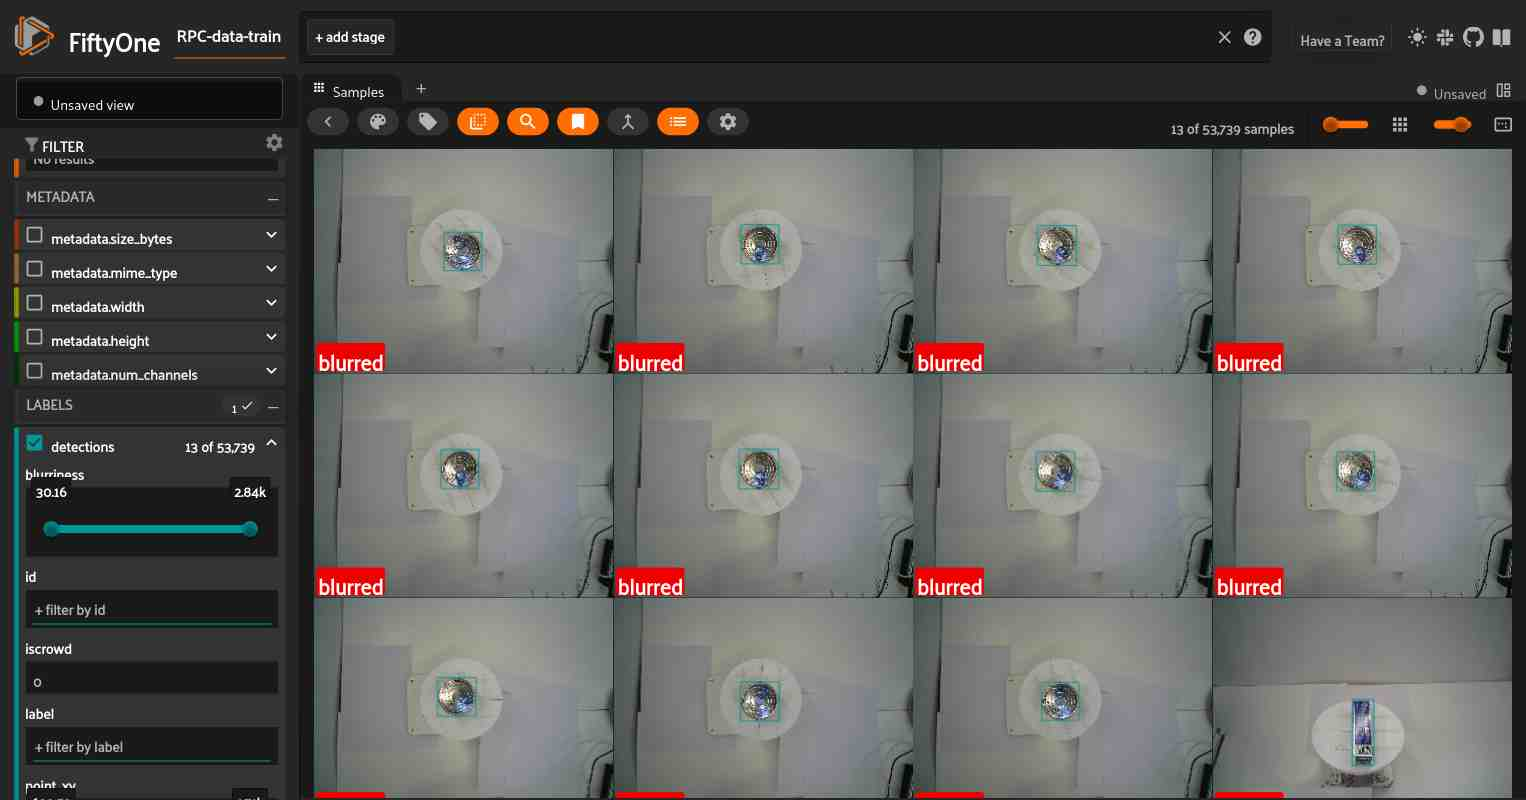

In [26]:
# Launch the FiftyOne app to visualize
session = fo.launch_app(train_dataset)

In [ ]:
session.freeze()

## Finding Duplicate or Similar Images

Identifying duplicate or similar images can help reduce redundancy and improve dataset quality. 

Using **FiftyOne Brain**'s `compute_similarity` functionality, we can locate similar images within the dataset. This feature leverages embeddings to index samples or patches, enabling similarity-based querying and sorting.

To get started:

1. Assign a unique name to the Brain key, for example, `brain_key="my_brain_key"`.

2. Use the key to apply similarity functions and filter duplicates based on a chosen metric, such as **cosine similarity**.

For further tools and plugins related to image deduplication, refer to this [GitHub repository](https://github.com/jacobmarks/image-deduplication-plugin/tree/main).

In [29]:
fob.compute_similarity(
    val_dataset,
    brain_key="my_brain_key",
    model_name="clip-vit-base32-torch",
    metric="cosine",
    )

Computing embeddings...
 100% |███████████████| 6000/6000 [8.8m elapsed, 0s remaining, 11.1 samples/s]      



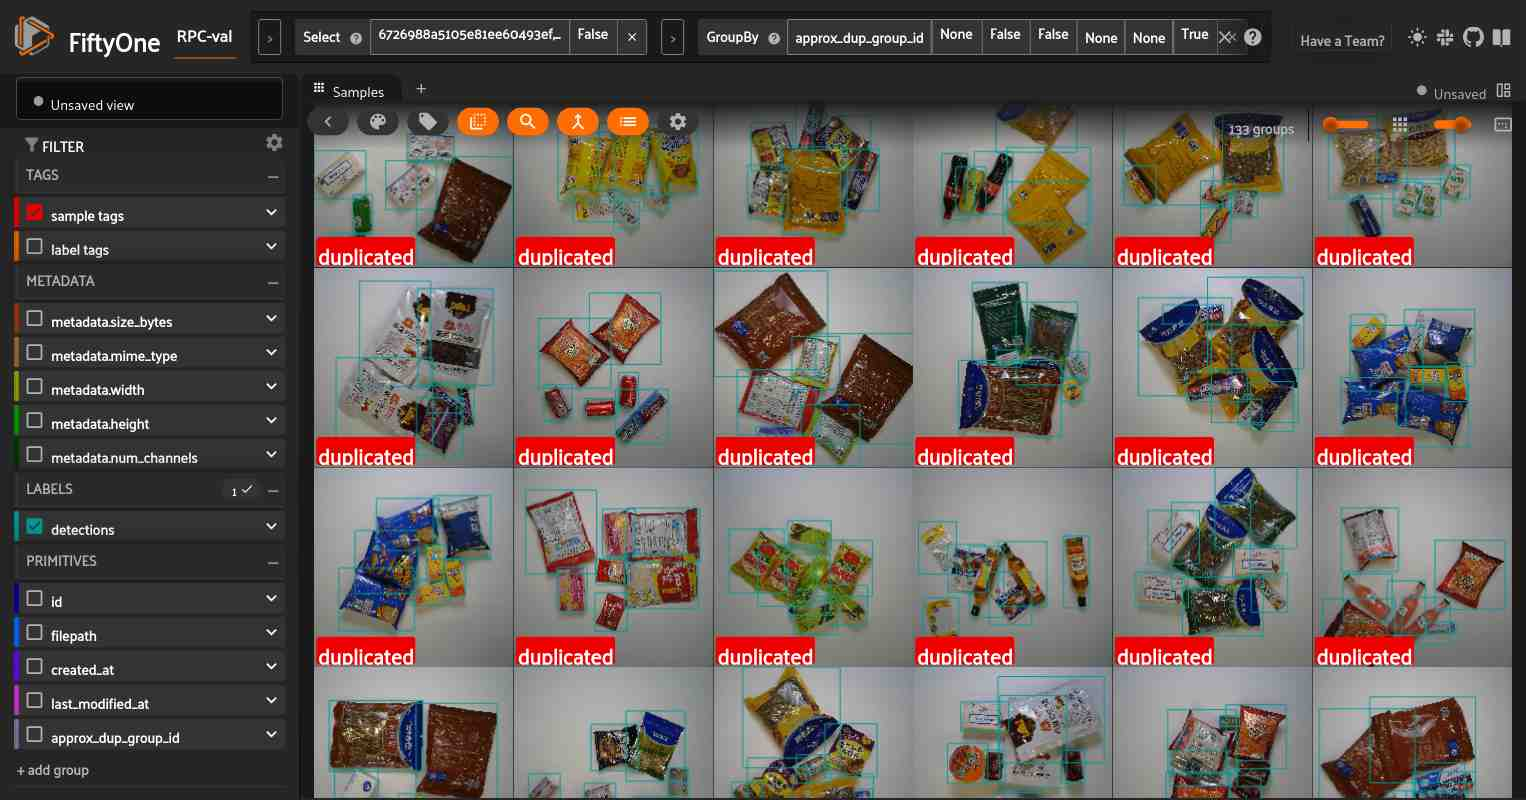

In [30]:
session = fo.launch_app(val_dataset)

In [ ]:
session.freeze()

## Working with Selected Samples

One of FiftyOne’s powerful features is the ability to select and tag samples dynamically, not only for visualization but also for further analysis. 

For example, you can capture a subset of sample IDs from your current session and create a new sub-dataset to perform additional operations.

With FiftyOne, you can easily **tag, organize, and manipulate** selected samples for various tasks, from quality inspection to focused model training and evaluation.

In [ ]:
# Retrieve selected sample IDs from the session
sample_ids = session.selected

# Create a sub-dataset using the selected sample IDs
samples = val_dataset.select(sample_ids)
samples

Dataset:     RPC-val
Media type:  image
Num samples: 133
Sample fields:
    id:                  fiftyone.core.fields.ObjectIdField
    filepath:            fiftyone.core.fields.StringField
    tags:                fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:          fiftyone.core.fields.DateTimeField
    last_modified_at:    fiftyone.core.fields.DateTimeField
    detections:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    approx_dup_group_id: fiftyone.core.fields.StringField
View stages:
    1. Select(sample_ids=['672698795105e81ee603de1a', '6726987a5105e81ee603de58', '6726987a5105e81ee603e01f', ...], ordered=False)

## Identifying Unique Images

While finding duplicates is useful, identifying unique images can also provide valuable insights into the dataset. 

FiftyOne makes it easy to assess the uniqueness of each image, allowing us to focus on distinctive samples that contribute the most variety.

Using the `compute_uniqueness` function, we can add a **uniqueness score** to each sample in the dataset, evaluating how unique it is compared to the rest of the samples. 

This method leverages only pixel data, making it applicable to both labeled and unlabeled samples. 

If no embeddings or model is provided, FiftyOne uses a default model to generate embeddings.

In [ ]:
# Add a uniqueness score field to each sample in the validation dataset
fob.compute_uniqueness(val_dataset,
                       uniqueness_field='unique',
                       )


Computing embeddings...
 100% |███████████████| 6000/6000 [46.0s elapsed, 0s remaining, 130.2 samples/s]      
Computing uniqueness...
Uniqueness computation complete



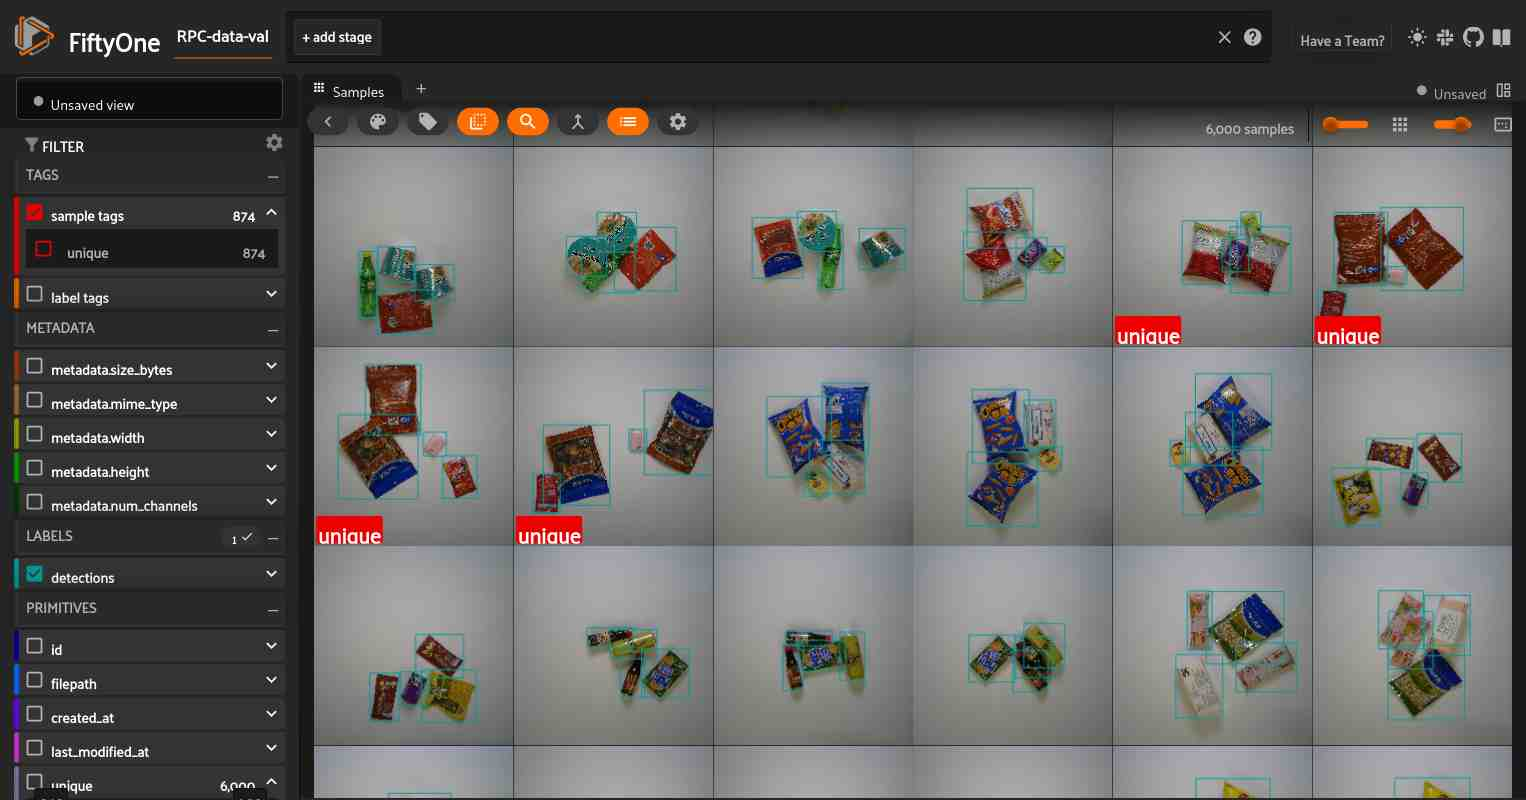

In [71]:
session = fo.launch_app(val_dataset)

In [ ]:
session.freeze()

## Evaluating the Fine-Tuned YOLO Model

With data preparation complete, we can now proceed to model evaluation. We'll start by loading our pre-trained YOLO model from Hugging Face and testing it on the prepared dataset to generate predictions.

### Loading the Model
To load the fine-tuned model, use the following link:
[Fine-Tuned Model](https://huggingface.co/vanshi-jain/RPC-model/resolve/main/best.pt)

Once loaded, we can begin testing the model on our dataset.

### Evaluation Overview
FiftyOne's Evaluation API provides tools for assessing model performance, allowing us to compute metrics such as:
- **Precision**: Proportion of correct positive detections.
- **Recall**: Ability to detect all relevant instances.
- **Mean Average Precision (mAP)**: Measures overall model accuracy, commonly used for object detection.

We'll dive into these metrics further as we analyze the model’s predictions on our dataset.

With these evaluation tools, we can ensure that the fine-tuned model meets our accuracy goals and is ready for real-world applications.


In [74]:
model = YOLO(f"https://huggingface.co/vanshi-jain/RPC-model/resolve/main/best.pt")
model

100%|██████████| 5.37M/5.37M [00:00<00:00, 15.1MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

## Running Predictions

Once the fine-tuned model is loaded, we can start generating predictions. To speed up testing, we’ll randomly select 5,000 images from the test set, which consists of 24,000 images. 

This allows us to obtain quick, representative insights into the model’s performance without processing the entire dataset.

Using FiftyOne’s `apply_model` function, we can apply our model to any dataset and store the predictions in a specified field `label_field `.

In [134]:
# randomly take 5000 images from test set to make the predictions faster
view_test_data = test_dataset.take(5000)

view_test_data.apply_model(
    model=model,
    label_field='predictions'
)

 100% |███████████████| 5000/5000 [13.5m elapsed, 0s remaining, 6.4 samples/s]      



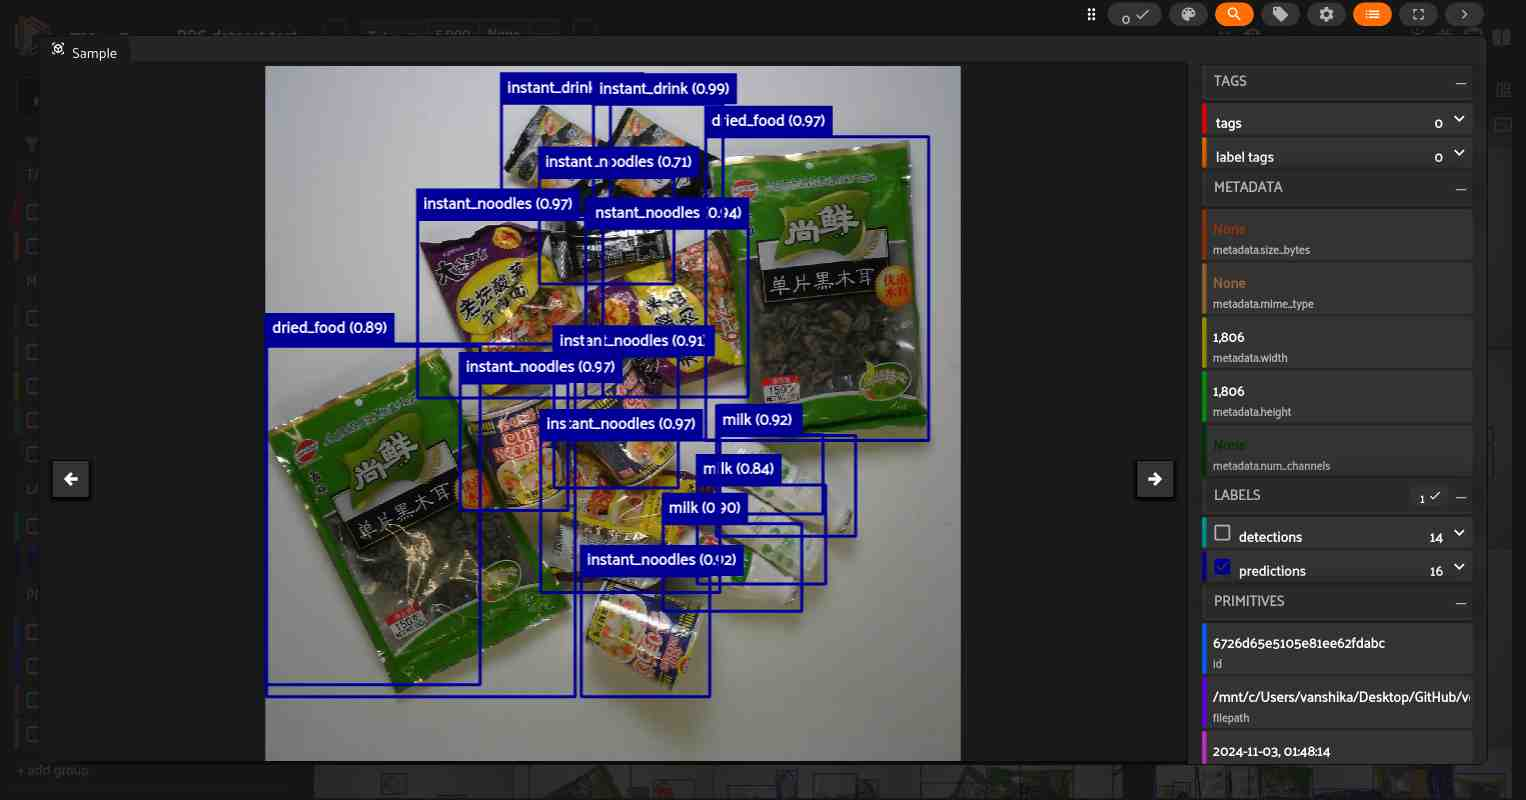

In [135]:
session = fo.launch_app(view_test_data)

In [ ]:
session.freeze()

## Evaluating Detections

The `evaluate_detections` function in FiftyOne allows us to assess the performance of our model by comparing the predicted detections with the ground-truth labels in the test dataset. This evaluation is crucial for understanding how well the model is performing in detecting objects.

### Evaluation Parameters

- **gt_field**: Specifies the field containing the ground truth labels (actual object locations).
  - **Example**: `detections`
  
- **pred_field**: Indicates the field with the predicted object detections (outputs from the YOLOv8 model).
  - **Example**: `predictions`

- **eval_key**: A key under which the evaluation results will be stored in the dataset.
  - **Example**: `eval`

- **classes**: A list of object categories that are being evaluated. This helps in breaking down performance metrics by class.

- **compute_mAP**: A Boolean flag that, when set to `True`, calculates the mean Average Precision (mAP) score.

In [7]:
classes = view_test_data.distinct("detections.detections.label")

# this will take some time so sit back and relax
detection_results = view_test_data.evaluate_detections(
    gt_field="detections",
    pred_field="predictions",
    eval_key="eval",
    classes=classes,
    compute_mAP = True
)

Evaluating detections...
 100% |███████████████| 5000/5000 [1.5m elapsed, 0s remaining, 60.3 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [1.1m elapsed, 0s remaining, 83.8 samples/s]      


In [ ]:
# get all the info on the evaluation by providing the specific 'eval_key' on the dataset
info = view_test_data.get_evaluation_info("eval")
print(info)

{
    "key": "eval",
    "version": "1.0.1",
    "timestamp": "2024-11-03T23:07:17.922000",
    "config": {
        "cls": "fiftyone.utils.eval.coco.COCOEvaluationConfig",
        "type": "detection",
        "method": "coco",
        "pred_field": "predictions",
        "gt_field": "detections",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "iscrowd",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "compute_mAP": true,
        "iou_threshs": [
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95
        ],
        "max_preds": 100,
        "error_level": 1
    }
}


In [11]:
# map_score = detection_results.mAP() * 100

### Top 10 Classes

To gain deeper insights into the model's performance, we can focus on the top 10 classes based on their mean Average Precision (mAP) scores. 

This allows us to analyze specific metrics such as precision, recall, and F1-score for each of these classes.

In [142]:
counts = view_test_data.count_values("detections.detections.label")

top10_classes = sorted(
    counts,
    key=counts.get,
    reverse=True
)[:10]

detection_results.print_report(classes=top10_classes)

                 precision    recall  f1-score   support

         tissue       0.99      0.98      0.98      5589
        dessert       0.83      0.97      0.90      5182
          drink       0.75      0.96      0.84      4927
      chocolate       0.83      0.98      0.90      3947
       seasoner       0.85      0.95      0.90      3925
    puffed_food       0.97      0.99      0.98      3874
instant_noodles       0.86      0.99      0.92      3784
    canned_food       0.91      0.93      0.92      3680
           milk       0.89      0.94      0.91      3419
        alcohol       0.74      0.94      0.83      3409

      micro avg       0.86      0.96      0.91     41736
      macro avg       0.86      0.96      0.91     41736
   weighted avg       0.86      0.96      0.91     41736



In [ ]:
detection_results.confusion_matrix()
# detection_results.plot_confusion_matrix()
# detection_results.plot_pr_curves()

array([[ 628,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  664,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  736,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  798,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1029,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  558,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  557,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  964,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  523,    0,    0,    0,    0,    0,    0,    0,    0],
 

### Identifying Hard Samples

To gain deeper insights into the model's predictions, the evaluation API provides access to true positives (TP), false positives (FP), and false negatives (FN). While true positives are crucial for measuring accuracy, understanding where the model fails is equally important for improving its performance.

#### Understanding Predictions

In the following example, we analyze a set of images to illustrate the distinction between TP, FP, and FN:

- **True Positives (TP)**: Correctly predicted objects. In the first image, the red box represents 7 true positives.
  
- **False Positives (FP)**: Incorrectly predicted objects that do not correspond to any ground truth. In the first image, the orange box indicates 3 false positives.
  
- **False Negatives (FN)**: Objects that were not detected by the model but are present in the ground truth. In the first image, the brown box indicates 0 false negatives.

#### Example Analysis

- In this specific image, the model made a total of 10 predictions:

  - **TP**: 7 (correct detections)

  - **FP**: 3 (incorrect detections)
  
  - **FN**: 0 (missed detections)

By analyzing these metrics, we can identify hard samples (images where the model struggles) allowing us to focus our efforts on improving detection accuracy.



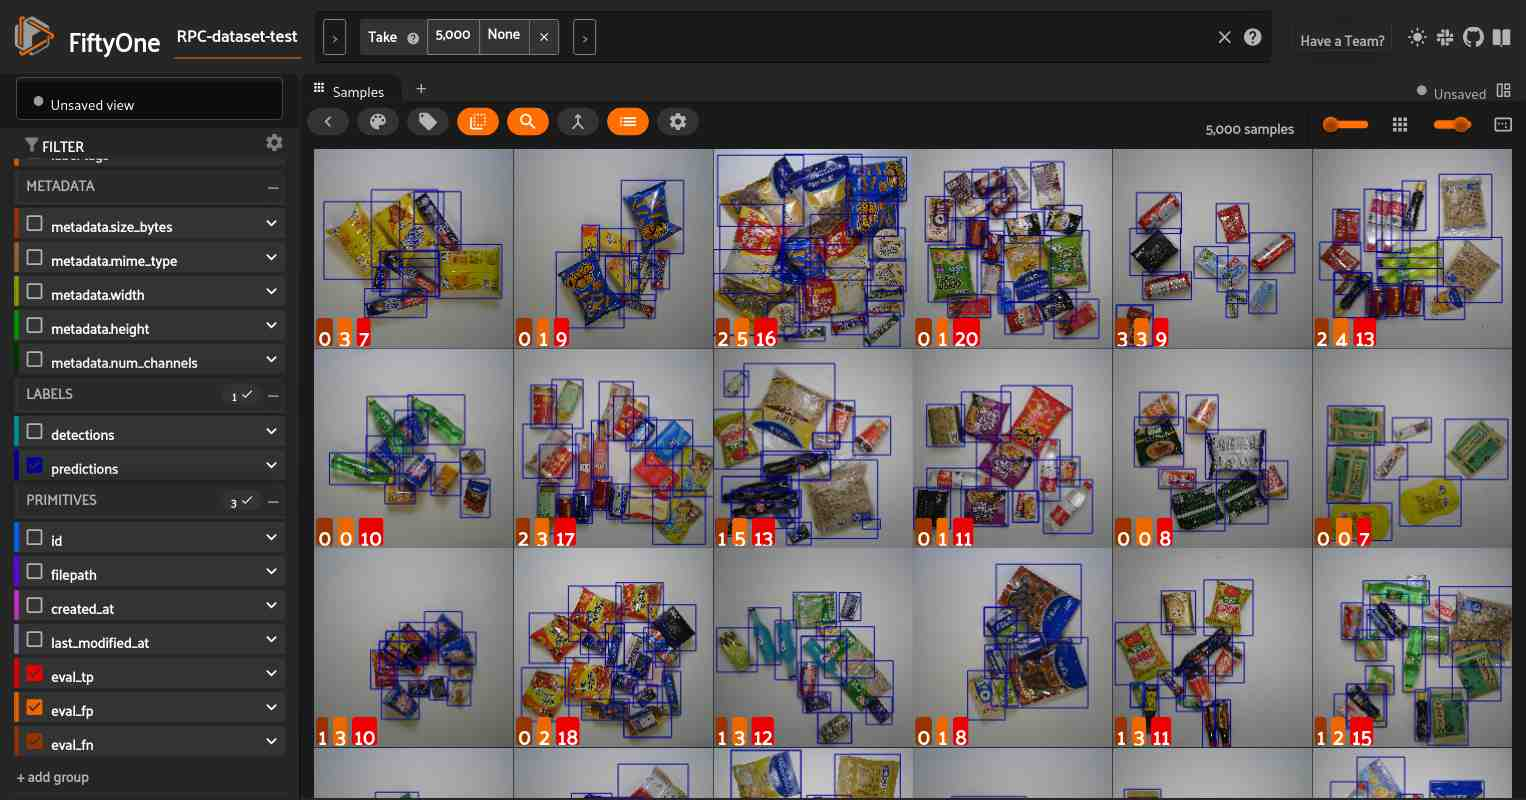

In [140]:
session = fo.launch_app(view_test_data)

In [ ]:
session.freeze()

### Closer Look at Predictions

To better understand the model's performance, particularly the false negatives, we can examine individual predictions closely. 

#### Example

In the evaluation of one sample image, we identify a false negative:

- **True Detection (Ground Truth)**: The actual label is **'instant_drink'**, represented by a light green box.
  
- **Predicted Detection**: The model predicts this object as **'candy'**, indicated by a dark blue box.

This misclassification highlights a situation where the model failed to correctly identify an object it should have recognized.

By visualizing the true label and predicted label side by side, we gain valuable insights into where the model is making mistakes. 

#### Benefits of Visualization

- **Identify Misclassifications**: Seeing the predicted labels alongside the true labels helps pinpoint exactly where the model struggles.
  
- **Analyze Patterns**: Repeated misclassifications can reveal patterns that might indicate confusion between similar classes, prompting further investigation into model training and data quality.

- **Improve Model Performance**: Understanding these discrepancies provides a roadmap for targeted improvements, such as refining the training dataset or adjusting model parameters.

This detailed analysis of individual predictions is crucial for enhancing the accuracy and reliability of the object detection model, ultimately leading to better performance in real-world applications.


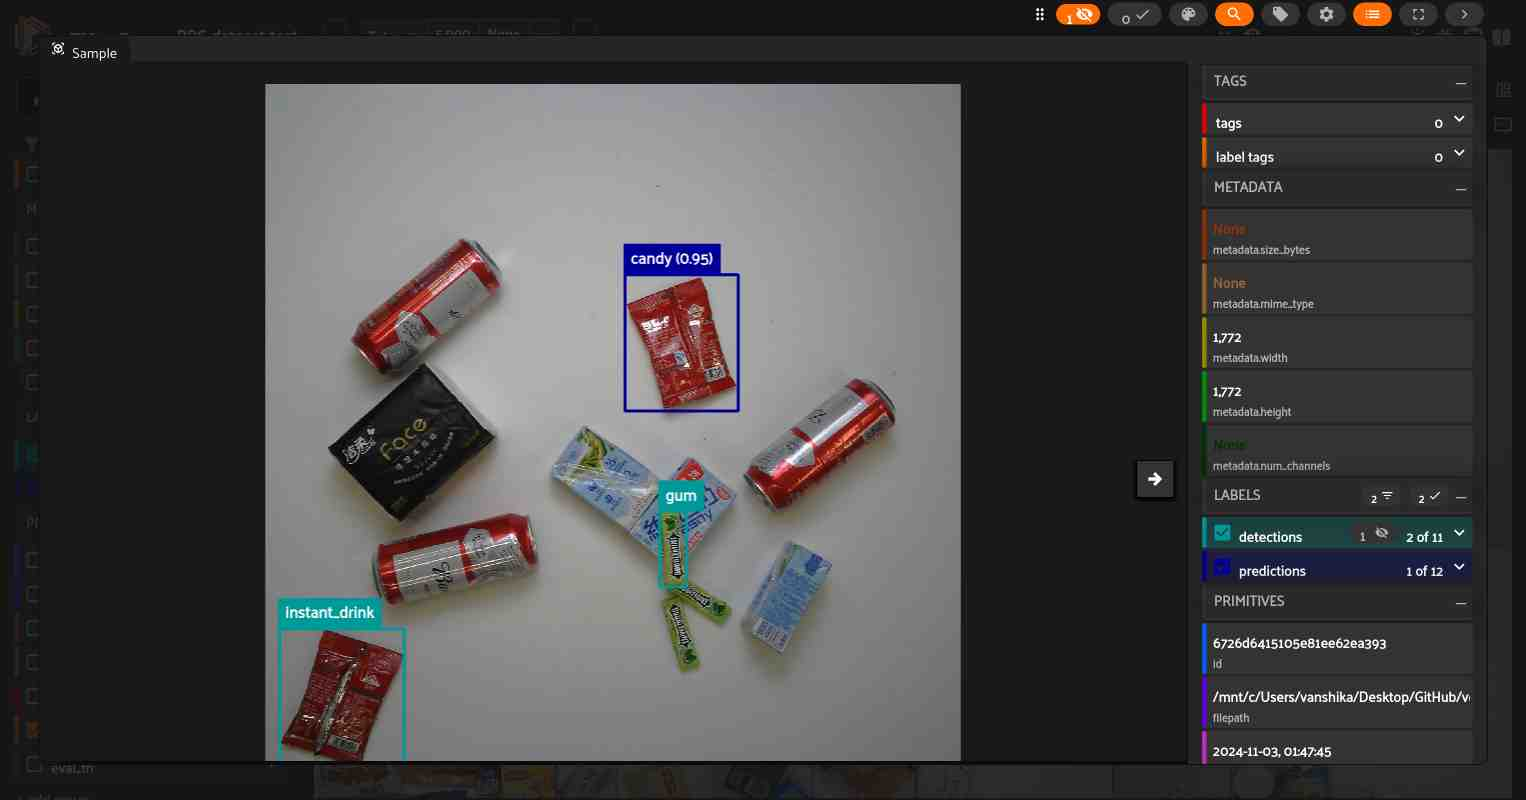

In [151]:
session = fo.launch_app(view_test_data)

In [ ]:
session.freeze()

## Conclusion

YOLOv8 marks a significant advancement in real-time object detection technology. However, it is primarily designed for general-purpose applications. 

Therefore, before deploying the model on specialized datasets like the Retail Product Checkout (RPC) dataset, it is essential to evaluate its performance on your specific data thoroughly. 

This evaluation allows for fine-tuning the YOLOv8 architecture to better meet your unique requirements.

By using FiftyOne, you can visualize and analyze the predictions made by YOLOv8, gaining deeper insights into the model's performance on the RPC dataset. 

This process is crucial for ensuring that your detection model is tailored to real-world challenges, where precision and adaptability are vital for success. 

With the right adjustments and evaluations, your YOLOv8 model can be optimized for effective and reliable object detection in retail environments.